In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import sys
sys.path.append('../')

from proxy_apps.framework.gpu import GPU
from proxy_apps.apps import LSTMProxyApp
from proxy_apps.data.grid import TransientDataset


2022-12-09 12:16:55.269609: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Initialize App

In [2]:
# get the framework
framework = GPU(
    machine_name="deception"
)

# get the interface
interface = framework.use_pytorch()

# load the proxy app
app = LSTMProxyApp("gpu")

[INFO] Device Type: cpu
[WARNING] No GPUs found, falling back to CPUs
[INFO] Python Data Type: float64
[INFO] Framework Data Type: torch.float64


In [3]:
# init app manager
interface.init_app_manager(
    app=app,
    app_name="LSTMProxyApp",
    output_dir="/qfs/people/jain432/pacer_remote/output/test/",
    mixed_precision_support=True,
    mgpu_support=True
)


[INFO] Selected App: LSTMProxyApp
[INFO] Output Data Directory: /qfs/people/jain432/pacer_remote/output/test
[INFO] App Supports Mixed Precision: True
[INFO] App Supports MGPUs: True
[INFO] Disabling Multi-GPU Support. To use multiple gpus, provide a valid Multi-GPU strategy (HVD/DDP) when initializing the framework.


## Load Data and Prepare Dataloader

In [4]:
# initialize data manager
interface.init_data_manager(
    data_dir="/qfs/people/jain432/pacer_remote/data/NewTestScenarios/",
    file_format="mat",
    data_manager="TimeSeries",
    train_files=2,
    test_files="/qfs/people/jain432/pacer_remote/data/TrainingDataIEEE68bus/",
    val_files=0,
    shuffle=True
)


[INFO] Training Data Directory: /qfs/people/jain432/pacer_remote/data/NewTestScenarios/
[INFO] Found 180 `mat` files
[INFO] Training on 2/180 `mat` files
[INFO] Validation on 0/180 `mat` files
[INFO] Testing on 30/180 `mat` files
[INFO] Number of training files: 2
[INFO] Number of validation files: 0


In [5]:
print(
    "Train (%d): %s\nVal (%d): %s\nTest (%d): %s" 
    %(
        len(interface.data_manager._TRAIN_FILES),
        interface.data_manager._TRAIN_DATA_DIR, 
        len(interface.data_manager._VAL_FILES),
        interface.data_manager._VAL_DATA_DIR,
        len(interface.data_manager._TEST_FILES),
        interface.data_manager._TEST_DATA_DIR
    )
)

Train (180): /qfs/people/jain432/pacer_remote/data/NewTestScenarios/
Val (0): /qfs/people/jain432/pacer_remote/data/NewTestScenarios/
Test (30): /qfs/people/jain432/pacer_remote/data/TrainingDataIEEE68bus/


In [6]:
# print(
#     interface.data_manager._TRAINING_FILES,
#     interface.data_manager._VAL_FILES,
#     interface.data_manager._TEST_FILES
# )

In [7]:
print(
    interface.data_manager._N_TRAIN_FILES,
    interface.data_manager._N_VAL_FILES,
    interface.data_manager._N_TEST_FILES
)

2 0 30


In [8]:
# load training data
load_prep_params = {
	"dataloader": "torch.utils.data.Dataset",
	"n_rows": 1400,
	"n_cols": 136,
	"repeat_cols": 1,
	"iw_params": {
		"window_size": 60,
		"shift_size": 1,
		"stride": 1,
		"start_at": 0,
		"leave_last": 33
	},
	"ow_params": {
		"window_size": 30,
		"shift_size": 1,
		"stride": 1,
		"start_at": 60,
		"leave_last": 3
	}
}
# training data
training_data = interface.load_data(
    data_files=interface.data_manager._TRAIN_FILES,
    data_params=load_prep_params,
    sampler=None,
	batch_size=64
)
# test data
test_data = interface.load_data(
    data_files=interface.data_manager._TEST_FILES,
    data_params=load_prep_params,
    sampler=None
)

In [9]:
inputs, targets = iter(training_data).next()
inputs.shape

torch.Size([64, 60, 136])

In [10]:
def plot_sample(dataloader, data_file, suptitle):
    # read from dataloader
    inputs, targets = iter(dataloader).next()
    
    # read actual data
    dataset = TransientDataset(data_file)
    raw_data = np.concatenate([dataset.F, dataset.Vm], axis=1)
    split_index = 136 // 2
    scale_factor = 2*np.pi
    raw_data[:, :split_index] = scale_factor*(raw_data[:, :split_index] - 60)
    raw_data[:, split_index:] = 10*(raw_data[:, split_index:] - 1)

    # compare actual and window data
    fig, axes = plt.subplots(2, 2, figsize=(9, 8))
    ax=axes[0,0]
    ax.plot(inputs[0, :, :]);
    ax.set_title("Dataloader (Window-1)")
    ax=axes[0,1]
    ax.plot(raw_data[:60, :]);
    ax.set_title("Actual Data (Window-1)")
    ax=axes[1,0]
    ax.plot(targets[0, :, :]);
    ax.set_title("Dataloader (Window-2)")
    ax=axes[1,1]
    ax.plot(raw_data[60:90, :]);
    ax.set_title("Actual Data (Window-2)")
    fig.tight_layout()
    fig.suptitle(suptitle)

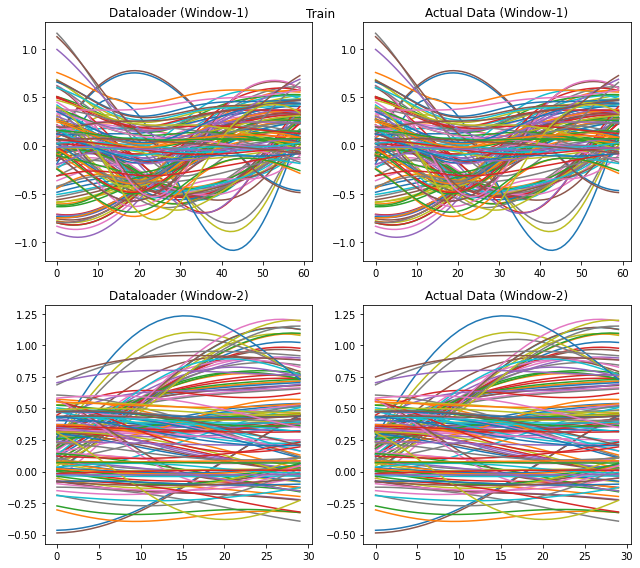

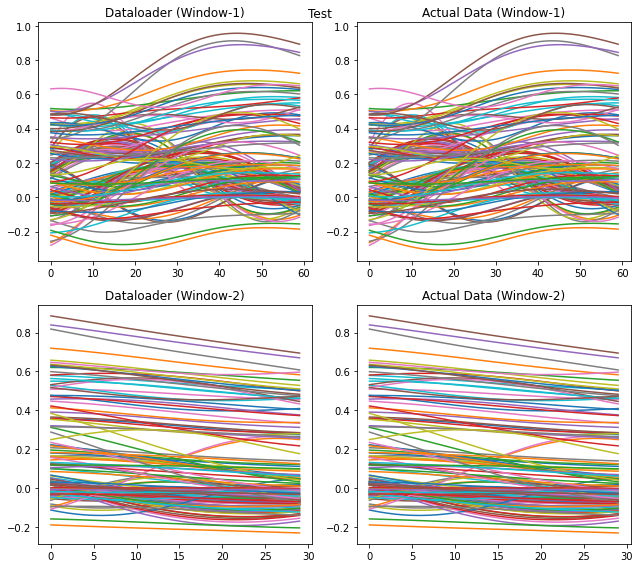

In [11]:
plot_sample(
    training_data,
    interface.data_manager._TRAIN_FILES[0],
    "Train"
)

plot_sample(
    test_data,
    interface.data_manager._TEST_FILES[0],
    "Test"
)

## Modeling

In [12]:
data_params = {
    "bw_size": 60,
    "fw_size": 30,
    "n_features": 136
}
opt_parameters = {
    "learning_rate"      : 5e-4,
    "momentum"      : 0.0,
    "weight_decay"  : 3e-4	
}
# train model
interface.init_training_engine(
    model_name="LSTM",
    model_dir="/qfs/people/jain432/pacer_remote/models/ProxyTSPRD_IPDPS/",
    data_params=data_params,
    opt_params=opt_parameters,
    criterion_params=None
)
# interface.train(
#     training_data=training_data,
#     n_epochs=20
# )

RuntimeError: Error(s) in loading state_dict for PTLSTM:
	Unexpected key(s) in state_dict: "lstm1_layer.weight_ih_l0", "lstm1_layer.weight_hh_l0", "lstm1_layer.bias_ih_l0", "lstm1_layer.bias_hh_l0", "lstm2_layer.weight_ih_l0", "lstm2_layer.weight_hh_l0", "lstm2_layer.bias_ih_l0", "lstm2_layer.bias_hh_l0", "lstm3_layer.weight_ih_l0", "lstm3_layer.weight_hh_l0", "lstm3_layer.bias_ih_l0", "lstm3_layer.bias_hh_l0". 
	size mismatch for lstm4_layer.weight_ih_l0: copying a param with shape torch.Size([256, 128]) from checkpoint, the shape in current model is torch.Size([256, 136]).

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in interface.model.state_dict():
    print(param_tensor, "\t", interface.model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in interface.optimizer.state_dict():
    print(var_name, "\t", interface.optimizer.state_dict()[var_name])

In [ ]:
predicted = interface.model(inputs)
predicted.shape

In [ ]:
# compare actual and window data
fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
ax=axes[0]
ax.plot(predicted.detach().numpy()[0, :, :]);
ax.set_title("Dataloader (Window-1)")
ax=axes[1]
ax.plot(targets[0, :, :]);
ax.set_title("Dataloader (Window-2)")
fig.tight_layout()